In [1]:
%matplotlib inline


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## NOTE
# The example in the book has the y label inverted.

In [2]:
X, y = load_breast_cancer(return_X_y=True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1
)

In [4]:
pipe_lr = make_pipeline(
    StandardScaler(), PCA(n_components=2), LogisticRegression(random_state=1)
)
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print(f"Test Accuracy: {pipe_lr.score(X_test, y_test):.3f}")

Test Accuracy: 0.956


In [5]:
kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True).split(
    X_train, y_train
)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(
        f"Fold: {k+1:2d}, Class dist.: {np.bincount(y_train[train])}, Acc: {score:.3f}"
    )

Fold:  1, Class dist.: [153 256], Acc: 1.000
Fold:  2, Class dist.: [153 256], Acc: 0.935
Fold:  3, Class dist.: [153 256], Acc: 0.913
Fold:  4, Class dist.: [153 256], Acc: 0.935
Fold:  5, Class dist.: [153 256], Acc: 0.978
Fold:  6, Class dist.: [153 257], Acc: 0.933
Fold:  7, Class dist.: [153 257], Acc: 0.933
Fold:  8, Class dist.: [153 257], Acc: 0.978
Fold:  9, Class dist.: [153 257], Acc: 0.956
Fold: 10, Class dist.: [153 257], Acc: 0.911


In [6]:
print(f"CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}")

CV accuracy: 0.947 +/- 0.028


In [7]:
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print(f"CV accuracy scores: {scores}")

CV accuracy scores: [0.97826087 0.93478261 0.95652174 0.93478261 0.91304348 0.95555556
 0.93333333 0.95555556 0.93333333 0.97777778]


In [8]:
print(f"CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}")

CV accuracy: 0.947 +/- 0.020


In [9]:
pipe_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty="l2", random_state=1, solver="lbfgs", max_iter=10000),
)

In [10]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    n_jobs=1,
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

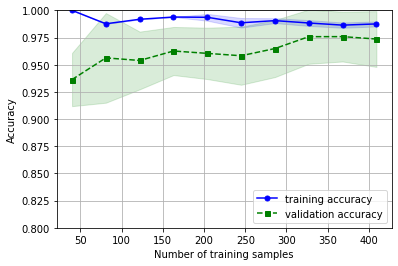

In [11]:
plt.plot(
    train_sizes,
    train_mean,
    color="blue",
    marker="o",
    markersize=5,
    label="training accuracy",
)
plt.fill_between(
    train_sizes,
    train_mean + train_std,
    train_mean - train_std,
    alpha=0.15,
    color="blue",
)
plt.plot(
    train_sizes,
    test_mean,
    color="green",
    linestyle="--",
    marker="s",
    markersize=5,
    label="validation accuracy",
)
plt.fill_between(
    train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color="green"
)
plt.grid()
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.ylim([0.8, 1.0])
plt.show()

In [12]:
from sklearn.model_selection import validation_curve

In [13]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name="logisticregression__C",
    param_range=param_range,
    cv=10,
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

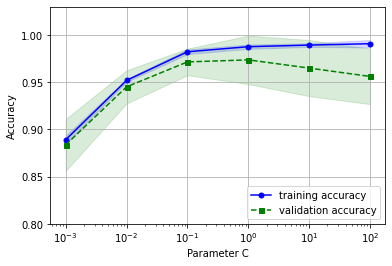

In [14]:
plt.plot(
    param_range,
    train_mean,
    color="blue",
    marker="o",
    markersize=5,
    label="training accuracy",
)
plt.fill_between(
    param_range,
    train_mean + train_std,
    train_mean - train_std,
    alpha=0.15,
    color="blue",
)
plt.plot(
    param_range,
    test_mean,
    color="green",
    linestyle="--",
    marker="s",
    markersize=5,
    label="validation accuracy",
)
plt.fill_between(
    param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color="green"
)
plt.grid()
plt.xscale("log")  # Important
plt.xlabel("Parameter C")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.ylim([0.8, 1.03])
plt.show()

# Tuning hyperparameters via grid search

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [16]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {"svc__C": param_range, "svc__kernel": ["linear"]},
    {"svc__C": param_range, "svc__kernel": ["rbf"], "svc__gamma": param_range},
]

gs = GridSearchCV(
    estimator=pipe_svc, param_grid=param_grid, scoring="accuracy", cv=10, n_jobs=-1
)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f"Test accuracy: {clf.score(X_test, y_test):.3f}")

0.9758454106280192
{'svc__C': 10.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Test accuracy: 0.982


In [17]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring="accuracy", cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring="accuracy", cv=5)
print(f"CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}")

CV accuracy: 0.971 +/- 0.011


In [18]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=0),
    param_grid=[{"max_depth": [1, 2, 3, 4, 5, 6, 7, None]}],
    scoring="accuracy",
    cv=2,
)

In [19]:
scores = cross_val_score(gs, X_train, y_train, scoring="accuracy", cv=5)
print(f"CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}")

CV accuracy: 0.932 +/- 0.013


In [21]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
confmat

array([[40,  2],
       [ 0, 72]])

Text(0, 0.5, 'predicted label')

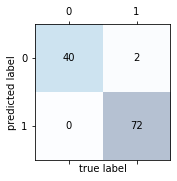

In [24]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va="center", ha="center")
plt.xlabel("true label")
plt.ylabel("predicted label")

In [40]:
tn, fp, fn, tp = confmat.ravel()
print("True negative", tn)
print("False positive", fp)
print("False negative", fn)
print("True positive", tp)

True negative 40
False positive 2
False negative 0
True positive 72


In [41]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
confmat

[[72  0]
 [ 2 40]]


In [26]:
from sklearn.metrics import f1_score, precision_score, recall_score

print(f"Precision: {precision_score(y_true=y_test, y_pred=y_pred):.3f}")
print(f"Recall: {recall_score(y_true=y_test, y_pred=y_pred):.3f}")
print(f"F1: {f1_score(y_true=y_test, y_pred=y_pred):.3f}")

Precision: 0.973
Recall: 1.000
F1: 0.986


In [29]:
# Construct own scorer using make_scorer

from sklearn.metrics import f1_score, make_scorer

scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.9662716450216451
{'svc__C': 10.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [42]:
# Plotting ROC

from numpy import interp
from sklearn.metrics import auc, roc_curve

pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression(penalty="l2", random_state=1, solver="lbfgs", C=100.0),
)

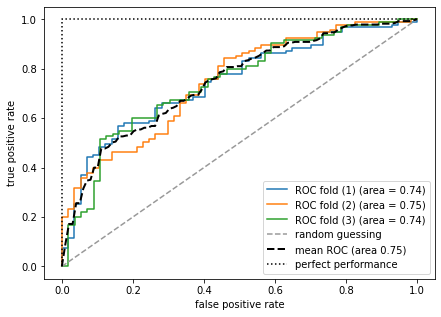

In [51]:
X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))


fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_trp = []


for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"ROC fold ({i+1}) (area = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color=(0.6, 0.6, 0.6), label="random guessing")

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, "k--", label=f"mean ROC (area {mean_auc:.2f})", lw=2)
plt.plot(
    [0, 0, 1], [0, 1, 1], linestyle=":", color="black", label="perfect performance"
)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="lower right")
plt.show()

In [57]:
# benign tumor = class 1
# malignant tumor = class 0
benign_counts = y.sum()
malignant_counts = len(y) - benign_counts
benign_counts, malignant_counts

(357, 212)

In [67]:
# Take all benign (class 1) and stack with imbalance data of 40 malignant to create imbalance dataset.
X_imb = np.vstack((X[y == 1], X[y == 0][:40]))
y_imb = np.hstack((y[y == 1], y[y == 0][:40]))
y_pred = np.ones(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [71]:
from sklearn.utils import resample

print("Number of malignant samples (class 0) before:", X_imb[y_imb == 0].shape[0])

X_upsampled, y_upsampled = resample(
    X_imb[y_imb == 0],
    y_imb[y_imb == 0],
    replace=True,
    n_samples=X_imb[y_imb == 1].shape[0],
    random_state=123,
)

print("Number of malignant samples (class 0) after:", X_upsampled.shape[0])

Number of malignant samples (class 0) before: 40
Number of malignant samples (class 0) after: 357


In [72]:
# After resampling, we can stack the original class 1 (benign samples) with the upsampled class 0 (malignant samples) to obtain a balanced dataset as follows

X_bal = np.vstack((X[y == 1], X_upsampled))
y_bal = np.hstack((y[y == 1], y_upsampled))

In [73]:
y_pred = np.ones(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0